## Rendering with mitsuba

This notebook demonstrates basic rendering with mitsuba and the python wrapper. 

The three basic classes that the mtspywrapper implements are the pyMedium, pySensor, pyEmitter. Currently there is only support of pyParallelRaySensor and pySolarEmitter.

In [1]:
" Load imports requiered for this notebook "

from mtspywrapper import pyMedium, pyParallelRaySensor, pySolarEmitter

# Mitsuba imports
from mitsuba.core import *
from mitsuba.render import Scene, RenderQueue, RenderJob
from mitsuba.core import PluginManager, Vector, Point, Transform, Spectrum

# Other imports 
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from tqdm import tqdm
import multiprocessing

scheduler = Scheduler.getInstance()
pmgr = PluginManager.getInstance()  

ncores = multiprocessing.cpu_count()

# Start up the scheduling system with one worker per local core
if not scheduler.isRunning():
    for i in range(0, ncores): 
        scheduler.registerWorker(LocalWorker(i, 'wrk%i' % i))
    scheduler.start()

#MTSPATH = next(path for path in sys.path if path.endswith('mitsuba'))
#BASEPATH = os.path.join(MTSPATH, 'notebooks')

In [2]:
def render_scene(scene, ncores=32):
    
    # Parallel rendering using the blocksize parameter for speed
    print('render_scene')
    queue = RenderQueue()
    size = scene.getSensor().getFilm().getSize()
    blocksize = max(np.divide(max(size.x, size.y), ncores), 1)
    scene.setBlockSize(blocksize) 
    bitmap = Bitmap(Bitmap.ELuminance, Bitmap.EFloat32, size)
    job = RenderJob('myRenderJob', scene, queue)
    job.start()
    queue.waitLeft(0)
    
    # Develop the camera's film 
    scene.getFilm().develop(Point2i(0, 0), size, Point2i(0, 0), bitmap)
    radiance = np.array(bitmap.buffer()) 
    return radiance

In [3]:
"""
Define the extinction field (\beta) in [km^-1]
""" 
tau = np.hstack((np.full(16, 2.00), np.full(16, 18.00)))
bounding_box = [0, 0, 0, 0.5, 0.5, 0.25]   # [xmin, ymin, zmin, xmax, ymax, zmax] in km units
geometrical_thickness = bounding_box[5] - bounding_box[2]
beta = tau/geometrical_thickness

In [4]:
"""
Define a pyMedium object with beta, bounding_box, boundary conditions, 
phase function and single scattering albedo
""" 
scene_type = 'step'
medium = pyMedium()
medium.set_boundary(x='periodic', y='periodic')
medium.set_phase(0.85)
medium.set_albedo(1)
medium.set_density(beta, bounding_box)
medium_str = medium.medium_to_mitsuba(scene_type)

In [5]:
"""
Define a pySolarEmitter object with solar zenith and azimuth angles [degrees]
""" 
solar_emitter = pySolarEmitter(zenith=0.0, azimuth=0.0)

In [6]:
"""
Define a pyParallelRaySensor object for the medium using the view zenith and azimuth angles [degrees] and num_samples
This sensor measures exisiting radiance from the top of the domain in a specific direction. 
It's pixel resolution is defined by the medium resolution.
""" 
sensor = pyParallelRaySensor(medium)
sensor.set_world_transform(view_zenith=0.0, view_azimuth=0.0)
sensor.set_sampler(num_samples=2**10)

In [7]:
"""
Define a mitsuba scene using all the python wrapper objects defined previously
""" 
rr_depth = 300     # Russian Roulette depth

scene = Scene()
# Set the integrator
scene.addChild(pmgr.create({
    'type' : 'volpath_simple',
    'rrDepth' : rr_depth
}))
# Add the sensor 
scene.addChild(sensor.get_mitsuba_sensor())
# Add heterogeneous medium
scene.addChild(medium_str)
# Create medium bounding box
scene.addChild(medium.bounding_box_to_mitsuba(scene_type))
# Add Emitter
scene.addChild(solar_emitter.get_mitsuba_emitter())
scene.configure()

In [8]:
print('rendering...')
radiance = render_scene(scene, ncores=ncores)
print('Finished rendering!')

rendering...
render_scene
Finished rendering!


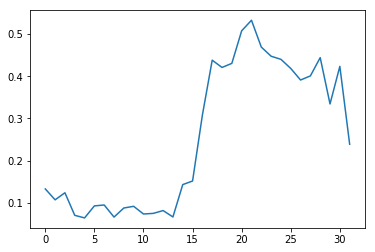

In [9]:
"""
Plot the brf measurements graph
"""
brf = radiance * solar_emitter.brf_factor
%matplotlib inline
plt.plot(brf.T)